In [1]:
# Ensure that GPU is selected: Runtime > Change runtime type

# This notebook is a streamlined version of the more detailed tutorial at:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

TorchVision Object Detection Finetuning Tutorial
================================================


In [2]:
!pip install torch torchvision matplotlib pillow


In [3]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2


In [4]:
import sys
sys.path.append('/content/gdrive/MyDrive/EAI6010/torchvisionreferencedetection/torchvision-reference-derection')

In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [6]:
# Set the random seed to ensure reproducibility
import random
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Give the notebook access to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import os
# Specify the path to your dataset
dataset_path = "/content/gdrive/MyDrive/EAI6010"

# Change the current working directory to the dataset path
os.chdir(dataset_path)

# Verify the change by listing the contents of the directory
print(os.listdir("."))

['train.csv', 'test.csv', 'yolo-animal-detection-small']


In [8]:
# Let's see what's in the image folder
print( f"image directory:\n{os.listdir( 'yolo-animal-detection-small')}")

image directory:
['train', '.DS_Store', 'test']


In [9]:
train_csv_path = "/content/gdrive/MyDrive/EAI6010/train.csv"
test_csv_path = "/content/gdrive/MyDrive/EAI6010/test.csv"
train_images = "/content/gdrive/MyDrive/EAI6010/yolo-animal-detection-small/train"
test_images = "/content/gdrive/MyDrive/EAI6010/yolo-animal-detection-small/test"

In [10]:
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316


In [11]:
train_csv.shape

(1309, 8)

In [12]:
test_csv = pd.read_csv(test_csv_path)
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_000.jpg,474,632,cat,103,72,436,603
1,cats_007.jpg,474,266,cat,301,37,460,265
2,cats_007.jpg,474,266,cat,90,1,392,266
3,cats_050.jpg,474,237,cat,157,40,314,205
4,cats_072.jpg,474,266,cat,187,1,474,266


In [13]:
test_csv.shape

(113, 8)

In [14]:
categories = train_csv["class"].unique()
print(categories)

['cat' 'monkey' 'dog']


In [15]:
# encode classes to integers

# 0 is for background by default

class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [16]:
label_map = LabelMap(categories)

In [17]:
train_csv = label_map.fit(train_csv, "class")
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,1,132,1,347,264
1,cats_002.jpg,474,474,1,176,44,467,433
2,cats_003.jpg,474,314,1,53,1,397,314
3,cats_004.jpg,474,355,1,1,1,393,335
4,cats_005.jpg,474,316,1,80,1,407,316


In [18]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_000.jpg,474,632,1,103,72,436,603
1,cats_007.jpg,474,266,1,301,37,460,265
2,cats_007.jpg,474,266,1,90,1,392,266
3,cats_050.jpg,474,237,1,157,40,314,205
4,cats_072.jpg,474,266,1,187,1,474,266


Creating Torch dataset



In [19]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class AnimalDataset(Dataset):
    def __init__(self, df, image_path, categories, transforms=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])

        # Check if the image file exists
        if not os.path.exists(image_file):
            raise FileNotFoundError(f"Image file not found: {image_file}")

        img = cv2.imread(image_file)

        # Check if the image was loaded successfully
        if img is None:
            raise ValueError(f"Failed to load image: {image_file}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)

        return torch.as_tensor(img, dtype=torch.float32), target

    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]


Defining augmentations and transforms for training and validation


In [20]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [21]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [22]:
transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [23]:
# initilize dataset
train_dataset = AnimalDataset(train_csv, train_images, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_images, categories, transform_test)

Creating dataloaders from datasets

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting images from dataloader

In [25]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

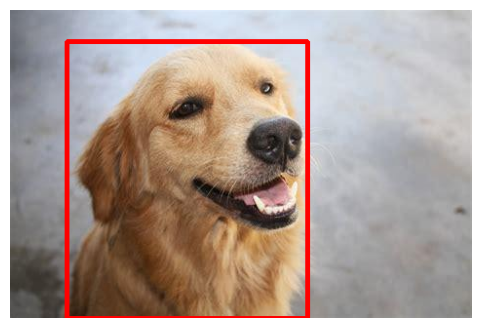

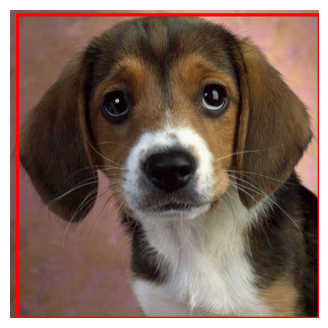

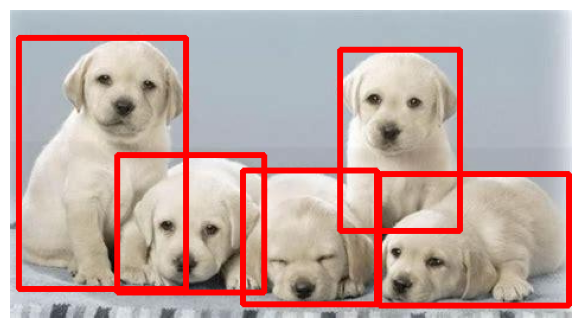

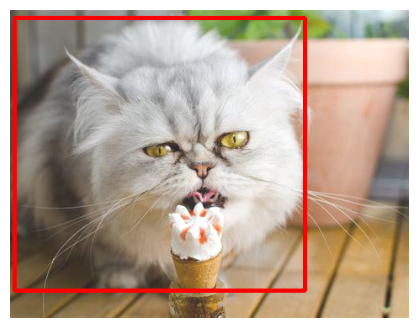

In [26]:
images, targets = next(iter(data_loader_train))
plot_images(images, targets)


Defining model

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(categories)+1  # + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Let's now write the main function which performs the training and the
validation:


In [29]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/118]  eta: 0:10:14  lr: 0.000048  loss: 2.3377 (2.3377)  loss_classifier: 1.3242 (1.3242)  loss_box_reg: 0.2144 (0.2144)  loss_objectness: 0.7012 (0.7012)  loss_rpn_box_reg: 0.0979 (0.0979)  time: 5.2061  data: 0.6555  max mem: 8061
Epoch: [0]  [ 10/118]  eta: 0:02:18  lr: 0.000475  loss: 2.1833 (2.2360)  loss_classifier: 1.2757 (1.2407)  loss_box_reg: 0.0935 (0.0982)  loss_objectness: 0.6951 (0.6987)  loss_rpn_box_reg: 0.1587 (0.1983)  time: 1.2780  data: 0.0995  max mem: 12726
Epoch: [0]  [ 20/118]  eta: 0:01:41  lr: 0.000902  loss: 2.0429 (1.8958)  loss_classifier: 1.0145 (0.9431)  loss_box_reg: 0.1002 (0.1094)  loss_objectness: 0.6891 (0.6776)  loss_rpn_box_reg: 0.1480 (0.1657)  time: 0.8296  data: 0.0333  max mem: 12726
Epoch: [0]  [ 30/118]  eta: 0:01:21  lr: 0.001328  loss: 1.2908 (1.6857)  loss_classifier: 0.3916 (0.7566)  loss_box_reg: 0.1133 (0.1253)  loss_objectness: 0.6184 (0.6390)  loss_rpn_box_reg: 0.1170 (0.1648)  time: 0.7398  data: 0.0245  max mem: 127

AssertionError: Results do not correspond to current coco set

But what do the predictions look like? Let's take one image in the
dataset and verify


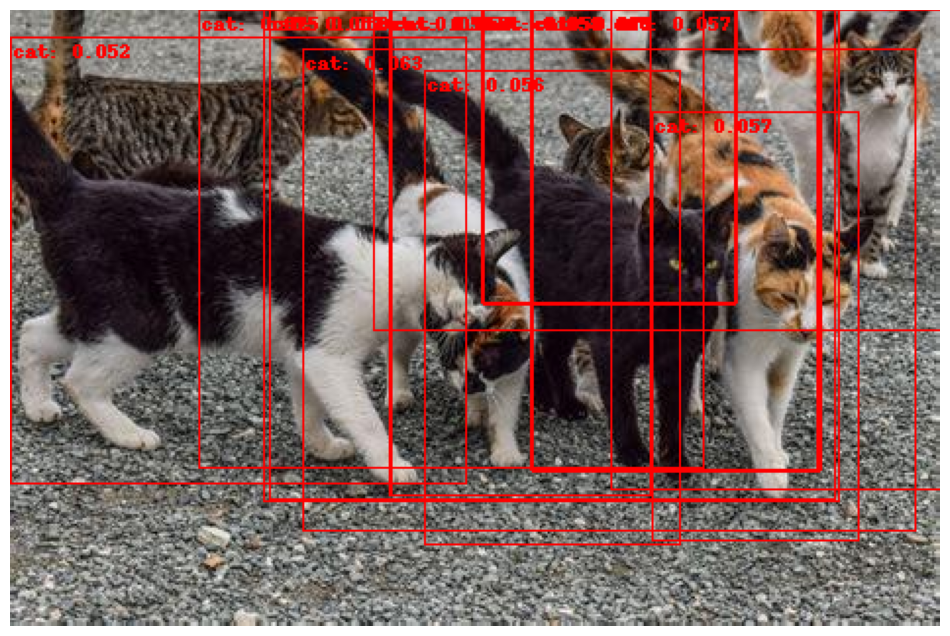

In [44]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import transforms
from PIL import Image

# Load the image
image_path = "/content/gdrive/MyDrive/EAI6010/yolo-animal-detection-small/test/cats_groups_031.jpg"
image = Image.open(image_path)

# Define the transformations, including converting to tensor
eval_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to a tensor
    # Add other necessary transformations here
])

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # Convert RGBA to RGB if necessary and move to device
    if x.shape[0] == 4:
        x = x[:3, ...]

    # Move the tensor to the appropriate device
    x = x.to(device)

    # Make predictions
    predictions = model([x])
    pred = predictions[0]

# Normalize the image tensor and convert to 8-bit if needed
x = (255.0 * (x - x.min()) / (x.max() - x.min())).to(torch.uint8)

# Generate prediction labels
pred_labels = [f"cat: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

# Draw bounding boxes on the image tensor
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(x, pred_boxes, labels=pred_labels, colors="red")

# Move the image tensor back to CPU for visualization
output_image = output_image.cpu()

# Convert the tensor to a PIL image for visualization
output_pil_image = transforms.ToPILImage()(output_image)

# Display the image using matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(output_pil_image)
plt.axis('off')  # Hide the axis
plt.show()
